In [1]:
% matplotlib inline

from scikits.talkbox.features import mfcc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import soundfile as sf
import pyaudio as pa
import os

random_state=24

音声ファイルimport

In [2]:
files = []
datapath = 'wav_data/'

for x in os.listdir(datapath):  
    if '.wav' in x:
        files.append(x)

各クラスのデータ数をそろえる

In [59]:
hu_count = 0
ti_count = 0
improved_files = []
for f in files:
    if '-hu.' in f:
        if hu_count < 18:
            hu_count += 1
            improved_files.append(f)
    elif '-ti.' in f:
        if ti_count < 18:
            ti_count += 1
            improved_files.append(f)
    else:
        improved_files.append(f)

del files
files = improved_files

mfccで特徴量とラベルのセット作成

In [60]:
import scipy.fftpack
def smoothing(abs_cry_array):
    N = len(abs_cry_array)
    fc = 0.001
    
    F = np.fft.fft(abs_cry_array)/(N/2)
    
    freq = np.fft.fftfreq(len(abs_cry_array))
    
    F[0] = F[0]/2
    
    F[(freq > fc)] = 0
    F[(freq < 0)] = 0
    
    f2 = np.fft.ifft(F)*(2*N/2)
    
    return f2

In [58]:
def devide_cry(cry_array, dist=10, thred=0.0002, loop=10):
    # 0を削除
    #cry_array = cry_array[cry_array > 1e-10]
    
    # 傾きのリストをつくる
    smoothed_abs_cry_array = smoothing(np.abs(cry_array))
    dx_array = [(smoothed_abs_cry_array[i + dist] - smoothed_abs_cry_array[i]) / dist for i in range(len(smoothed_abs_cry_array) - dist)]
    dx_array = dx_array + [dx_array[-1]] * dist
    
    devided_cry_list = []
    start_ix = 0
    end_ix=0
    
    #for i in range(len(dx_array)):
        
    
    return dx_array

In [7]:
label_dict = {'hu':0, 'ti':1, 'dc':2}

X = []
y = []
x_seq = []
for f in files:
    x, sample_rate = sf.read(datapath + f)
    x_seq.append(x)
    x = np.clip(x, 1e-10, 1)
    ceps,mspec,spec = mfcc(x, nwin=256, nfft=512, fs=8000, nceps=13)
    X.append(np.mean(ceps, axis=0))
    if '-hu.' in f:
        y.append(label_dict['hu'])
    elif '-ti.' in f:
        y.append(label_dict['ti'])
    else:
        y.append(label_dict['dc'])

X = np.array(X)
y = np.array(y)

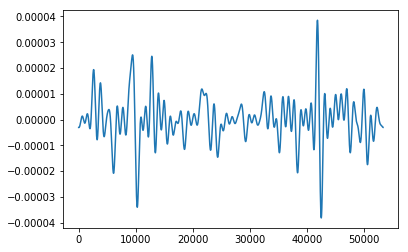

In [61]:
plt.plot(devide_cry(np.abs(x_seq[3])))
plt.show()

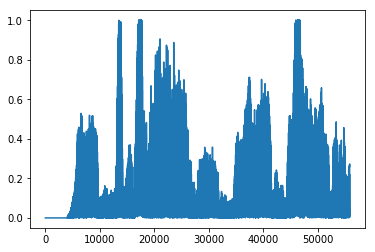

In [31]:
plt.plot(np.abs(x_seq[0]))
#plt.xlim(21000, 21100)
plt.show()

In [20]:
x_seq[1][9900:9910]

array([-0.03259277, -0.03131104, -0.02316284, -0.01577759, -0.00134277,
        0.01318359,  0.02258301,  0.02087402,  0.00997925, -0.00274658])

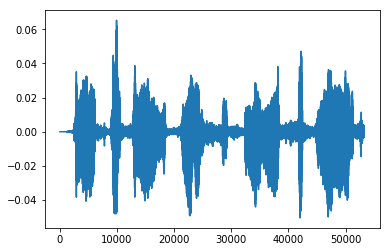

In [55]:
plt.plot(x_seq[3])
#plt.xlim(21000, 21100)
plt.show()

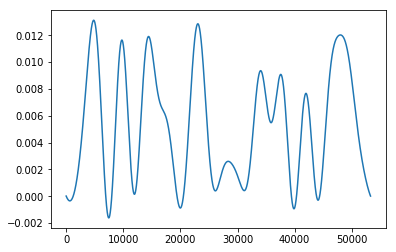

In [54]:
plt.plot(smoothing(np.abs(x_seq[3])))
#plt.xlim(21000, 23100)
plt.show()

welchメソッドによるパワースペクトルで特徴量とラベルのセット作成

In [147]:
import scipy.signal

label_dict = {'hu':0, 'ti':1, 'dc':2}

X = []
y = []

fs = 8000
nperseg = 128
nfft=1024
for f in files:
    x, sample_rate = sf.read(datapath + f)
    freq, P = scipy.signal.welch(x, fs, window='hamming', nperseg=nperseg, nfft=nfft)
    X.append(P)
    if '-hu.' in f:
        y.append(label_dict['hu'])
    elif '-ti.' in f:
        y.append(label_dict['ti'])
    else:
        y.append(label_dict['dc'])

X = np.array(X)
y = np.array(y)

In [150]:
# 圧縮
from sklearn.decomposition import PCA
pca = PCA(n_components=13, random_state=random_state)
X = pca.fit_transform(X)

分類器で学習、評価

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score

precision = 0
recall = 0
f_value = 0

n_splits = 5

skf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
for train_index, test_index in skf.split(X, y):
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    #clf = LinearSVC(random_state=random_state)
    clf = RandomForestClassifier(n_estimators=17, random_state=random_state)
    # clf = XGBClassifier(max_depth=5, learning_rate=0.05, seed=random_state)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_valid)
    precision += precision_score(y_valid, pred, average='macro')
    recall += recall_score(y_valid, pred, average='macro')
    f_value += f1_score(y_valid, pred, average='macro')

precision = precision / float(n_splits)
recall = recall / float(n_splits)
f_value = f_value / float(n_splits)

In [14]:
precision

0.45018518518518513

In [80]:
pred

array([1, 0, 0, 2, 1, 0, 0, 2, 0, 2, 2, 1])